In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1JmKH5iYX4Hw6lDhMOXr74soCQMO2pUjI'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Data.zip')
!unzip Data.zip > /dev/null
del downloaded


# Upload and prepare data

In [0]:
import pandas as pd
from PIL import Image
import torchvision
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.determenistic = True

train_sheet = pd.read_csv('CheXpert-v1.0-small/train.csv')
classes = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation','Edema', 'Pleural Effusion', 'Enlarged Cardiomediastinum',  'Lung Opacity',
'Lung Lesion', 'Pneumonia', 'Pneumothorax',  'Pleural Other', 'Fracture']


In [0]:
def to_listImage(pillowImage):
  pixels = pillowImage.load()
  width, height = pillowImage.size
  listImage = []
  for j in range(height):
    currentRow = []
    for i in range(width):
      currentRow.append(pixels[i,j])
    listImage.append(currentRow)
  return listImage

In [0]:
def uploadData(sheet, start_index, batch_size):
  x_batch = []
  y_batch = []

  for i in range (start_index, start_index + batch_size, 1):
      if ((i + 1) >= len(sheet['Path'])):
        break

      currentImg = Image.open(sheet['Path'][i])
      currentImg = currentImg.resize((384, 320))
      currentImg = to_listImage(currentImg)
      x_batch.append(currentImg)
      currentLabels = []
      for disease in classes:
        if (sheet[disease][i] == 1):
          currentLabels.append(1)
        else:
          currentLabels.append(0)
      y_batch.append(currentLabels)

  return (x_batch, y_batch)
  
   

In [0]:
import matplotlib.pyplot as plt

def show_tensorImage(tensorImage, title = ''):
    image = tensorImage.numpy()
    plt.imshow(image)
    plt.title(title)
    plt.show()
    plt.pause(0.001)

# Training

In [0]:
device = torch.device('cuda:0')
model = torchvision.models.densenet121(pretrained = False)
model.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=7, stride = 2, padding = (3,3), bias=False)
model.classifier = torch.nn.Linear(in_features = 1024, out_features=13)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3, amsgrad=True)
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)
loss = torch.nn.MultiLabelSoftMarginLoss()



In [0]:
def evaluateCompetitiveAccuracy(pred_classes, target):
  num_values = pred_classes.shape[0]*5
  total = 0
  for i in range(len(pred_classes)):
    for j in range(1,6):
      total += (pred_classes[i][j] == target[i][j]).float().cpu()
  return total/num_values        

In [0]:
def evaluateClass(pred):
  classes = pred
  for j in range(len(classes)):
    for i in range(len(classes[j])):
      if (classes[j][i] > 0.5):
        classes[j][i] = 1.0
      else:
        classes[j][i] = 0.0
  return classes

In [0]:
x, y = uploadData(train_sheet, 0, 20)
x = torch.FloatTensor(x)

In [0]:
def transform_list(listX, listY, device):
  tensorX = torch.FloatTensor(listX)
  tensorX.unsqueeze_(1)
  tensorX = tensorX/255
  tensorX = (tensorX - 0.229)/0.485
  tensorY = torch.LongTensor(listY)
  tensorX = tensorX.to(device)
  tensorY = tensorY.to(device)
  return (tensorX, tensorY)

In [0]:
import math
loss_history = []
accuracy_history = []
def train_model(num_epochs, batch_size):
  for ep in range(num_epochs):
    print('Epoch {}/{}:'.format(ep, num_epochs - 1), flush=True)
    accuracy_ep = 0
    loss_ep = 0
    for phase in ['train']:
      start_index = 0
      if (phase == 'train'):
        sheet = pd.read_csv('CheXpert-v1.0-small/train.csv')
        model.train()
        optimizer.zero_grad()
      else:
        sheet = pd.read_csv('CheXpert-v1.0-small/valid.csv')
        model.eval()
      num_batches = math.floor(len(sheet['Path'])/batch_size)
      while start_index < len(sheet['Path']):
        x_batch, y_batch = uploadData(sheet, start_index, batch_size)
        start_index += batch_size
        if len(x_batch) < batch_size:
          break                #такой случай возможен только для последнего батча, который почти во всех случаях будет неполным
       
        x_batch, y_batch = transform_list(x_batch, y_batch, device)    
        pred = model(x_batch)
        pred = torch.sigmoid(pred)
        loss_val = loss(pred, y_batch)
        if (phase == 'train'):
          loss_val.backward()
          optimizer.step()
          sched.step()

        pred_classes = evaluateClass(pred)
        
        run_accuracy = evaluateCompetitiveAccuracy(pred_classes, y_batch.data)
        run_loss = loss_val.item()
        accuracy_ep += run_accuracy
        loss_ep += run_loss
        loss_history.append(run_loss)
        accuracy_history.append(run_accuracy)
        del x_batch
        del y_batch
        torch.cuda.empty_cache()
        if (start_index % 2000 == 0):
          print('epoch = ', ep)
          print('phase = ', phase)
          print(start_index,'accuracy = ', run_accuracy)
          print(start_index,'loss = ', run_loss)
          print('\n')
      print(phase, 'epoch accuracy = ', accuracy_ep/num_batches)
      print(phase, 'epoch loss = ', loss_ep/num_batches)
    
    print(ep, 'epoch done!')


In [0]:
train_model(10, 20)

Epoch 0/9:
epoch =  0
phase =  train
2000 accuracy =  tensor(0.9300)
2000 loss =  0.6931473016738892


epoch =  0
phase =  train
4000 accuracy =  tensor(0.8100)
4000 loss =  0.6931473016738892


epoch =  0
phase =  train
6000 accuracy =  tensor(0.8300)
6000 loss =  0.6931473016738892


epoch =  0
phase =  train
8000 accuracy =  tensor(0.7200)
8000 loss =  0.6931473016738892


epoch =  0
phase =  train
10000 accuracy =  tensor(0.7600)
10000 loss =  0.6931473016738892


epoch =  0
phase =  train
12000 accuracy =  tensor(0.7700)
12000 loss =  0.6931473016738892


epoch =  0
phase =  train
14000 accuracy =  tensor(0.7600)
14000 loss =  0.6931473016738892


epoch =  0
phase =  train
16000 accuracy =  tensor(0.8000)
16000 loss =  0.6931473016738892


epoch =  0
phase =  train
18000 accuracy =  tensor(0.8200)
18000 loss =  0.6931473016738892


epoch =  0
phase =  train
20000 accuracy =  tensor(0.7900)
20000 loss =  0.6931473016738892


epoch =  0
phase =  train
22000 accuracy =  tensor(0.9000

KeyboardInterrupt: ignored

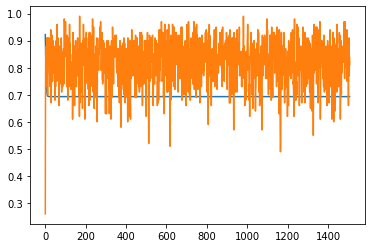

In [0]:
plt.plot(loss_history)
plt.plot(accuracy_history)

In [0]:
sum(accuracy_history)/len(accuracy_history)

tensor(0.8218)

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1kZuFeTf-ZY6cv3J5uCsNbUKOfpkbIbT-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('params.txt')

In [0]:
model.load_state_dict(torch.load('params.txt'))

<All keys matched successfully>

In [0]:
import math
def validate():
    batch_size = 20
    accuracy_val = 0
    loss_val = 0
    start_index = 0
    sheet = pd.read_csv('CheXpert-v1.0-small/valid.csv')
    model.eval()
    num_batches = math.floor(len(sheet['Path'])/batch_size)
    while start_index < len(sheet['Path']):
        x_batch, y_batch = uploadData(sheet, start_index, batch_size)
        start_index +=batch_size
        if len(x_batch) < batch_size:
          break                #такой случай возможен только для последнего батча, который почти во всех случаях будет неполным
       
        x_batch, y_batch = transform_list(x_batch, y_batch, device)    
        pred = model(x_batch)
        pred = torch.sigmoid(pred)
        loss_val = loss(pred, y_batch)

        pred_classes = evaluateClass(pred)
        run_accuracy = evaluateCompetitiveAccuracy(pred_classes, y_batch.data)
        run_loss = loss_val.item()
        accuracy_val += run_accuracy
        loss_val += run_loss
        del x_batch
        del y_batch
        torch.cuda.empty_cache()
        if (start_index % 2000 == 0):
          print('epoch = ', ep)
          print('phase = ', phase)
          print(start_index,'accuracy = ', run_accuracy)
          print(start_index,'loss = ', run_loss)
          print('\n')
    accuracy_val = accuracy_val/num_batches
    loss_val = loss_val/num_batches
    return (accuracy_val, loss_val)

In [0]:
acc, l = validate()

In [0]:
print(acc)
print(l)

tensor(0.7436)
tensor(0.1260, device='cuda:0', grad_fn=<DivBackward0>)


In [0]:
torch.save(model.state_dict(), 'paramsDensenet.txt')

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'paramsDensenet.txt'})
uploaded.SetContentFile('paramsDensenet.txt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1kZuFeTf-ZY6cv3J5uCsNbUKOfpkbIbT-
